# Private gardens and income in Sant Just using python

In this post we will focus on the analysis of private greenness and income for the town of Sant Just Desvern (Barcelona, Spain) using remote sensing data and python tools. The motivation behind this post is threefold. First, I'd like to  get more familiar with packages I have used but that I want to explore further (*geopandas*, *shapely*, *rasterio*, *folium*). Second, I will use the extracted information to correlate greenness with income in the city and thus test basic statistical capabilities. Third, Sant Just is my hometown and I'm always eager to explore in all angles! :)

This script was written in a Jupyter notebook and converted to a markdown file to be able to merge it in the *blogdown* R-based blog. Let's get started!

In [116]:
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from matplotlib import pyplot
import folium
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Before we start though, let's have a look at this beautiful town! (and try folium capabilities while at it! :) Sant Just is a residencial town neighbouring Barcelona touching the Collserola mountain range.

In [117]:
# Read boundaries
bound_file = "data/boundaries/sant-just.geojson"
stjust = gpd.read_file(bound_file)

# Start folium
f = folium.Figure(width=450, height=400)
m = folium.Map(location=[41.391421, 2.077184], zoom_start=13)

# Add boudnaries
folium.GeoJson(stjust, name='Sant Just boundaries').add_to(m)

# And process
folium.LayerControl().add_to(m)
f.add_child(m)
f

## Preprocessing boundaries and land cover

First, we read the municipality boundaries and the land cover data of the region. Land cover data correspond to CREAF are come in raster format and according to the documentation they are derived via supervised classification of Sentinel 2 data (10 m) and correspond to 2017. Data can be downloaded [here](https://territori.gencat.cat/ca/01_departament/12_cartografia_i_toponimia/bases_cartografiques/medi_ambient_i_sostenibilitat/usos-del-sol/). Prior to reading the data, I have clipped the raster to the boundary polygon of Sant Just to avoid a data overload, and polygonized it using GRASS. Here, we do some data cleaning to reclassify the land use types.

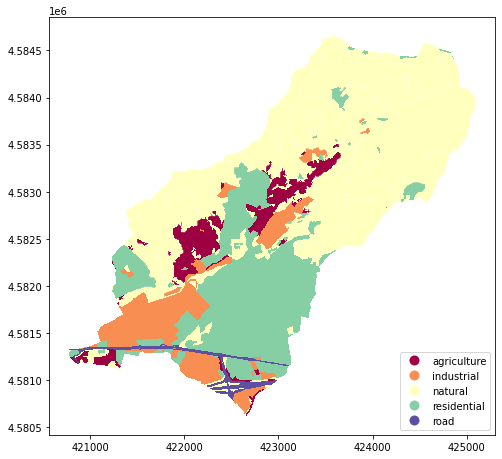

In [118]:
# Read land cover data
lc = gpd.read_file("data/landcover/lc-stjust.geojson")     

# Classes for reclassification
water = [1,2]
road = 4
residential = [5,6]
industrial = 7
agriculture = [8,9,10,11,12,24,25]
natural = list(range(9,25))
natural.append(3)

# Reclassify
lc["lctype"] = ''

for index, row in lc.iterrows():
    if row['DN'] in water:
        lc['lctype'].values[index] = 'water'
    elif row['DN'] == road:
        lc['lctype'].values[index] = 'road'
    elif row['DN'] in residential:
        lc['lctype'].values[index] = 'residential'
    elif row['DN'] == industrial:
        lc['lctype'].values[index] = 'industrial'
    elif row['DN'] in agriculture:
        lc['lctype'].values[index] = 'agriculture'
    elif row['DN'] in natural:
        lc['lctype'].values[index] = 'natural'

lc.plot(column = "lctype", cmap = "Spectral", legend = True, figsize = (8,8), legend_kwds={'loc': 'lower right'});

Since we are interested in private gardens only we will focus on the residential class. Note that since we do not have data on minor streets, street trees will be inevitably included in the data.

## Preprocessing remote sensing data

Now that our study area is defined, let's move on and read the remote sensing data, which can be freely downloaded at the Catalan Cartographic insitute in [this link](https://www.icgc.cat/Descarregues/Imatges-aeries-i-de-satel-lit/Altres-imatges-aeries), and corresponds to the RGB ortophotos and NIR data collected each year by the insitute at very high resolution, from which an NDVI layer is computed. I downloaded data for 2019 at 0.9m spatial resolution and cropped the data to our study area and resampled to 5m in QGIS before importing the data here. Let's exclude the non-residential areas, remove values smaller than 0 (possibly pools), and have a look.

In [119]:
# Open the data
ndvi = rio.open("data/remote_sensing/stjust_ndvi_5m.tif")
# print(ndvi.meta)

# Clip it
reslc = lc.loc[lc['lctype'] == 'residential'] # Filter residential polygons
geoms = [g for g in reslc['geometry']] # Extract geometry from residential polygons
out_image, out_transform = mask(ndvi, geoms, crop=False) # Mask
out_meta = ndvi.meta # Update metadata and write
out_meta.update({"transform": out_transform})

# Remove water
out_image[out_image<0] = np.nan

# Write to disk and open again!
with rio.open("data/remote_sensing/stjust_ndvi_5m_res_nowater.tif", "w", **out_meta) as dest:
    dest.write(out_image)
ndvi_pro = rio.open("data/remote_sensing/stjust_ndvi_5m_res_nowater.tif")

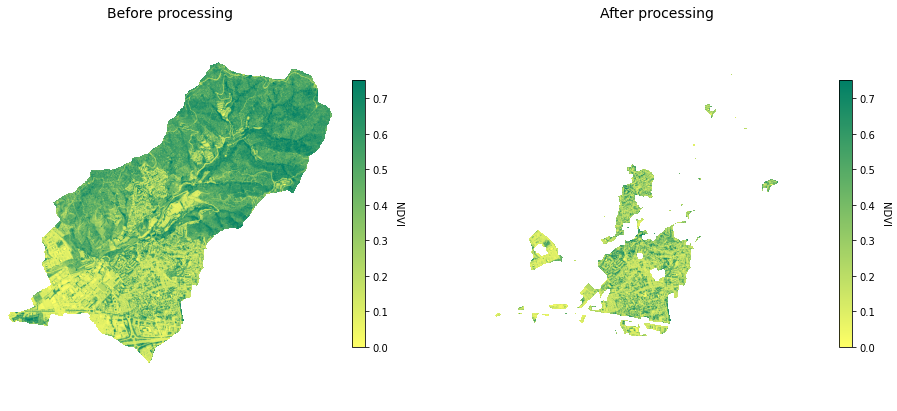

In [120]:
# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

# Plot 1: Before processing
ndviplot1 = ax1.imshow(ndvi.read(1), cmap='summer_r', vmin=0, vmax=0.75)
ax1.set_title("Before processing", fontsize=14)
cbar1 = fig.colorbar(ndviplot1, ax = ax1, shrink = 0.7)
cbar1.ax.get_yaxis().labelpad = 15
cbar1.ax.set_ylabel('NDVI', rotation=270)
ax1.set_axis_off()
ax1.axis('equal')

# Plot 2: Post-processing
ndviplot2 = ax2.imshow(ndvi_pro.read(1), cmap='summer_r', vmin=0, vmax=0.75)
ax2.set_title("After processing", fontsize=14)
cbar2 = fig.colorbar(ndviplot2, ax = ax2, shrink = 0.7)
cbar2.ax.get_yaxis().labelpad = 15
cbar2.ax.set_ylabel('NDVI', rotation=270)
ax2.set_axis_off()
ax2.axis('equal')

plt.show()

## Mean and median NDVI per census tract area

## Analysing the association between income and greenness